<a href="https://colab.research.google.com/github/MALLI7622/Brain-Decoding/blob/main/Brain_Decoding_%2B_Augmented_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fMRI_response_path = "/content/drive/MyDrive/Brain_Decoding_Data/EstimatedResponses.mat"
Images_path = "/content/drive/MyDrive/Brain_Decoding_Data/Stimuli.mat"

In [ ]:
import numpy as np
import h5py
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [ ]:
stim = h5py.File(fMRI_response_path, "r")

try:
    resp = h5py.File(Images_path, "r")
except:
    resp = loadmat(Images_path)

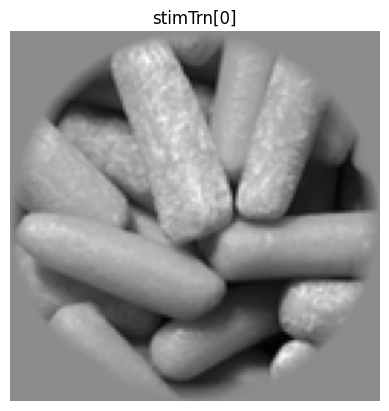

In [ ]:
idx = np.random.randint(0, resp['stimTrn'].shape[0])
plt.imshow(resp['stimTrn'][idx], cmap='gray', vmin=-0.55, vmax=0.45)
plt.axis('off')
plt.title("stimTrn[0]")
plt.show()

In [ ]:
clip_features_train = np.load("/content/drive/MyDrive/Brain_Decoding_Data/clip_features_natural_images.npy")
clip_features_val = np.load("/content/drive/MyDrive/Brain_Decoding_Data/clip_features_natural_images_val.npy")
print(clip_features_train.shape, clip_features_val.shape)

(1750, 768) (120, 768)


In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
from scipy.io import loadmat
import numpy as np
from transformers import CLIPProcessor, CLIPModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py

import torch
import torch.nn as nn

import torch
import torchvision.transforms as T
from PIL import Image
from scipy.io import loadmat
import numpy as np
from transformers import CLIPProcessor, CLIPModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py


import numpy as np
import h5py
from scipy.io import loadmat
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import random
import math
import torchvision.transforms as T

class AugmentedDiffusionDataset(Dataset):
    def __init__(
        self,
        clip_embeddings,              # [N, 768]
        images,                       # [N, 128, 128] in [0,1]
        clip_noise_std=0.05,          # global isotropic std if no residuals available
        clip_channel_dropout=0.08,    # prob. per-dimension to drop
        p_clip_gauss=0.9,             # prob. to apply gaussian jitter
        use_pca=False,
        pca_components=128,           # if use_pca, noise only on top-K comps
        p_img_aug=0.8                 # prob. to augment image
    ):
        self.clip_embeddings = torch.tensor(clip_embeddings, dtype=torch.float32)
        self.images = torch.tensor(images, dtype=torch.float32).unsqueeze(1)  # [N,1,128,128]

        # --- Image augs (gentle, content-preserving) ---
        self.img_aug = T.Compose([
            T.ConvertImageDtype(torch.float32),
            T.RandomApply([T.RandomAffine(degrees=4, translate=(0.03,0.03), scale=(0.95,1.05), fill=0.5)], p=0.5),
            T.RandomApply([T.RandomHorizontalFlip(p=1.0)], p=0.25),
            T.RandomApply([T.ColorJitter(brightness=0.10, contrast=0.10)], p=0.5),
            T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.3),
        ])
        self.p_img_aug = p_img_aug

        # --- CLIP-space noise setup ---
        self.clip_noise_std = clip_noise_std
        self.clip_channel_dropout = clip_channel_dropout
        self.p_clip_gauss = p_clip_gauss

        self.use_pca = use_pca
        if use_pca:
            X = self.clip_embeddings.numpy()
            Xc = X - X.mean(0, keepdims=True)
            # economical PCA
            U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
            self.pca_basis = torch.tensor(Vt[:pca_components], dtype=torch.float32)  # [K,768]
            self.clip_mean = torch.tensor(X.mean(0), dtype=torch.float32)
            # scale noise per-PC roughly to global std / sqrt(K)
            self.pca_noise_scale = clip_noise_std / math.sqrt(pca_components)

    def __len__(self):
        return len(self.clip_embeddings)

    def _augment_clip(self, e):
        # Channel dropout
        if self.clip_channel_dropout > 0:
            mask = torch.bernoulli((1.0 - self.clip_channel_dropout) * torch.ones_like(e))
            e = e * mask + (1 - mask) * 0.0  # drop to 0

        # Gaussian jitter (isotropic or PCA-directed)
        if random.random() < self.p_clip_gauss:
            if self.use_pca:
                # sample noise only in top-K subspace
                K = self.pca_basis.shape[0]
                z = torch.randn(K) * self.pca_noise_scale
                noise = torch.mv(self.pca_basis.t(), z)  # [768]
                e = e + noise
            else:
                e = e + torch.randn_like(e) * self.clip_noise_std
        return e

    def _augment_image(self, img):  # img in [1,128,128], range [0,1]
        if random.random() < self.p_img_aug:
            # torchvision expects [C,H,W] in [0,1]; our img is already [1,128,128]
            img = self.img_aug(img)
        return img

    def __getitem__(self, idx):
        e = self.clip_embeddings[idx]          # [768], float32
        x = self.images[idx]                   # [1,128,128], float32 in [0,1]
        # apply augs
        e = self._augment_clip(e)
        x = self._augment_image(x)
        # scale target image to [-1,1] as your training loop expects
        x = (x - 0.5) * 2.0
        return x, e


def mixup_collate(batch, alpha=0.2, p=0.5):
    """
    Batch-level MixUp in both embedding and image space.
    Targets are images, so we mix them too.
    """
    xs, es = zip(*batch)
    x = torch.stack(xs, dim=0)  # [B,1,128,128]
    e = torch.stack(es, dim=0)  # [B,768]

    if random.random() < p and len(batch) > 1:
        lam = np.random.beta(alpha, alpha)
        # random permutation for pairing
        perm = torch.randperm(x.size(0))
        x = lam * x + (1 - lam) * x[perm]
        e = lam * e + (1 - lam) * e[perm]
    return x, e

# --- usage ---
# train_dataset = AugmentedDiffusionDataset(clip_preds_train, train_labels,
#                                           clip_noise_std=0.05,
#                                           clip_channel_dropout=0.08,
#                                           use_pca=True, pca_components=128)
# train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True,
#                               collate_fn=lambda b: mixup_collate(b, alpha=0.2, p=0.5))


In [ ]:
train_labels = np.load("/content/drive/MyDrive/Brain_Decoding_Data/train_labels.npy")
clip_preds_train = np.load("/content/drive/MyDrive/Brain_Decoding_Data/clip_preds_train.npy")

In [ ]:
train_dataset = AugmentedDiffusionDataset(clip_preds_train, train_labels,
                                          clip_noise_std=0.05,
                                          clip_channel_dropout=0.08,
                                          use_pca=True, pca_components=128)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True,
                              collate_fn=lambda b: mixup_collate(b, alpha=0.2, p=0.5))

In [ ]:
len(train_dataset)

3500

In [ ]:
train_labels.shape, clip_preds_train.shape

((3500, 128, 128), (3500, 768))

In [ ]:
def get_timestep_embedding(timesteps, embedding_dim):
    device = timesteps.device
    half_dim = embedding_dim // 2
    emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    return emb  # shape [B, embedding_dim]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, cond_dim, num_groups=8):
        super().__init__()
        self.norm1 = nn.GroupNorm(num_groups=min(4, in_channels), num_channels=in_channels)
        self.norm2 = nn.GroupNorm(num_groups=min(4, out_channels), num_channels=out_channels)
        self.activation = nn.GELU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.film_mlp = nn.Sequential(
            nn.Linear(cond_dim, out_channels * 2),
            nn.GELU(),
            nn.Dropout(0.1)
        )

        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t_emb, cond_emb):
        h = self.activation(self.norm1(x))
        h = self.conv1(h)

        t = self.time_mlp(t_emb).view(x.size(0), -1, 1, 1)
        gamma_beta = self.film_mlp(cond_emb).view(x.size(0), -1, 1, 1)
        gamma, beta = torch.chunk(gamma_beta, 2, dim=1)

        h = gamma * h + beta + t  # FiLM + time injection

        h = self.activation(self.norm2(h))
        h = self.conv2(h)

        return h + self.residual_conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, cond_dim):
        super().__init__()
        self.res = ResidualBlock(in_ch, out_ch, time_emb_dim, cond_dim)
        self.down = nn.Conv2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)

    def forward(self, x, t, c):
        x = self.res(x, t, c)
        return self.down(x), x  # return downsampled and skip

class UpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, time_emb_dim, cond_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1)
        self.res = ResidualBlock(out_ch + skip_ch, out_ch, time_emb_dim, cond_dim)

    def forward(self, x, skip, t, c):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.res(x, t, c)

class ConditionedUNetWithSkips(nn.Module):
    def __init__(self, cond_dim=768, time_emb_dim=256, in_channels=1, base_channels=64):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.GELU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        self.init_cond_proj = nn.Conv2d(cond_dim, 1, kernel_size=1)  # for spatial conditioning injection

        self.down1 = DownBlock(in_channels + 1, base_channels, time_emb_dim, cond_dim)           # 1+1 → 128
        self.down2 = DownBlock(base_channels, base_channels * 2, time_emb_dim, cond_dim)      # 128 → 256
        self.down3 = DownBlock(base_channels * 2, base_channels * 4, time_emb_dim, cond_dim)  # 256 → 512
        self.down4 = DownBlock(base_channels * 4, base_channels * 8, time_emb_dim, cond_dim)  # 512 → 1024

        # Bottleneck
        self.bot = ResidualBlock(base_channels * 8, base_channels * 8, time_emb_dim, cond_dim)

        # Up path
        self.up4 = UpBlock(base_channels * 8, base_channels * 8, base_channels * 4, time_emb_dim, cond_dim)
        self.up3 = UpBlock(base_channels * 4, base_channels * 4, base_channels * 2, time_emb_dim, cond_dim)
        self.up2 = UpBlock(base_channels * 2, base_channels * 2, base_channels, time_emb_dim, cond_dim)
        self.up1 = UpBlock(base_channels, base_channels, base_channels, time_emb_dim, cond_dim)

        # Final output
        self.final = nn.Sequential(
            nn.Conv2d(base_channels, 1, kernel_size=1),
            nn.Tanh()
        )

    def forward(self, x, t, cond):
        # Spatial broadcast + projection of cond vector
        cond_map = cond.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, x.shape[2], x.shape[3])  # [B, 768, H, W]
        cond_proj = self.init_cond_proj(cond_map)  # [B, 1, H, W]
        x = torch.cat([x, cond_proj], dim=1)  # [B, 2, H, W]

        t_embed = get_timestep_embedding(t, self.time_emb_dim)
        t_emb = self.time_mlp(t_embed)

        d1, skip1 = self.down1(x, t_emb, cond)
        d2, skip2 = self.down2(d1, t_emb, cond)
        d3, skip3 = self.down3(d2, t_emb, cond)
        d4, skip4 = self.down4(d3, t_emb, cond)

        b = self.bot(d4, t_emb, cond)

        u4 = self.up4(b, skip4, t_emb, cond)
        u3 = self.up3(u4, skip3, t_emb, cond)
        u2 = self.up2(u3, skip2, t_emb, cond)
        u1 = self.up1(u2, skip1, t_emb, cond)

        return self.final(u1)


In [ ]:
class NoiseScheduler:
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02):
        self.timesteps = timesteps
        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def get_params(self, t):
        return self.alpha_bars[t], self.betas[t]
def preprocess_for_clip(img):
    img = F.interpolate(img, (224,224), mode='bilinear', align_corners=False)
    img = (img + 1) / 2
    img = img.repeat(1,3,1,1)
    mean = torch.tensor([0.48145466,0.4578275,0.40821073], device=img.device).view(1,3,1,1)
    std  = torch.tensor([0.26862954,0.26130258,0.27577711], device=img.device).view(1,3,1,1)
    return (img - mean) / std

In [ ]:
# 1. Instantiate model
model = ConditionedUNetWithSkips(
    cond_dim=768,        # your CLIP embedding size
    time_emb_dim=256,
    in_channels=1,       # grayscale input
    base_channels=128
)

# 2. Noise scheduler (you should define alpha_bars inside it)
scheduler = NoiseScheduler(timesteps=1000)

# 3. Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)


tensor(0.)

In [ ]:
from tqdm import tqdm_notebook as tqdm

In [ ]:
# ✅ Step 1: Enhanced Conditioning via FiLM + Concatenation already exists in your architecture.
# You use: cond_mlp + dropout injection (FiLM-style) → Good.
# To strengthen it further, let's apply early concatenation at input as well.

# Below is a training loop with:
# - cosine conditioning loss
# - weighted sum loss
# - early stopping
# - model saving
# - embedding alignment tracking

import torch
import torch.nn.functional as F
from torchvision.utils import save_image
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt


def cosine_loss(a, b):
    a_norm = F.normalize(a, dim=-1)
    b_norm = F.normalize(b, dim=-1)
    return 1 - (a_norm * b_norm).sum(dim=-1).mean()


def train_loop(
    model, dataloader, optimizer, scheduler, clip_model,
    lambda_cond = 1, device='cuda',
    max_epochs=50, early_stop_patience=5, save_path='best_model.pt'
):
    model = model.to(device)
    clip_model = clip_model.to(device).eval()

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(max_epochs):
        model.train()
        total_loss, total_diff, total_cond = 0, 0, 0
        batch_idx = 0
        for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]
            clip_cond = F.normalize(clip_cond, dim=-1)
            clip_cond = F.normalize(clip_cond + 0.01*torch.randn_like(clip_cond), dim=-1)
            x_0, clip_cond = x_0.to(device), clip_cond.to(device)
            B = x_0.size(0)
            t = torch.randint(0, scheduler.timesteps, (B,), device=device)
            # alpha_bar = scheduler.alpha_bars[t].view(B, 1, 1, 1).to(device)
            alpha_bar = scheduler.alpha_bars.to(t.device)[t].view(B, 1, 1, 1)

            noise = torch.randn_like(x_0)
            x_t = (alpha_bar.sqrt() * x_0 + (1 - alpha_bar).sqrt() * noise)

            # pred_noise = model(x_t, t.float() / scheduler.timesteps, clip_cond)
            pred_noise = model(x_t, t, clip_cond)
            loss_diff = F.mse_loss(pred_noise, noise)

            with torch.no_grad():
                x_0_pred = (x_t - (1 - alpha_bar).sqrt() * pred_noise) / alpha_bar.sqrt()
                x_0_pred = torch.clamp(x_0_pred, -1, 1)
                x_0_clip = preprocess_for_clip(x_0)
                x_0_pred_clip = preprocess_for_clip(x_0_pred)

                if batch_idx == 0:  # only do for first batch
                    x_0_clip = preprocess_for_clip(x_0)
                    x_0_pred_clip = preprocess_for_clip(x_0_pred)
                    plot_embedding_similarity(x_0_clip, x_0_pred_clip, clip_model)

                gt_embed = clip_model.get_image_features(x_0_clip)
                pred_embed = clip_model.get_image_features(x_0_pred_clip)

            loss_cond = cosine_loss(pred_embed, gt_embed)

            loss = loss_diff + lambda_cond * loss_cond

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_idx += 1

            total_loss += loss.item()
            total_diff += loss_diff.item()
            total_cond += loss_cond.item()

        avg_loss = total_loss / len(dataloader)
        avg_diff = total_diff / len(dataloader)
        avg_cond = total_cond / len(dataloader)

        print(f"Epoch {epoch+1}: Total={avg_loss:.4f}, Diff={avg_diff:.4f}, Cond={avg_cond:.4f}")

        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            patience_counter = 0
            print("✅ Saving new best model")
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("⏹️ Early stopping triggered")
                break


def plot_embedding_similarity(gt_imgs, gen_imgs, clip_model):
    with torch.no_grad():
        gt_embed = clip_model.get_image_features(gt_imgs)
        gen_embed = clip_model.get_image_features(gen_imgs)
        sim_matrix = cosine_similarity(gt_embed.cpu(), gen_embed.cpu())
        avg_sim = np.mean(np.diag(sim_matrix))

        print("Average Cosine Similarity:", avg_sim)

        # # 🔥 Plot the similarity heatmap
        # plt.figure(figsize=(12, 8))
        # sns.heatmap(sim_matrix, annot=True, fmt=".2f", cmap='viridis',
        #             xticklabels=[f"gen_{i}" for i in range(len(gen_imgs))],
        #             yticklabels=[f"gt_{i}" for i in range(len(gt_imgs))])
        # plt.title(f"Embedding Cosine Similarity (avg: {avg_sim:.2f})")
        # plt.xlabel("Generated Images")
        # plt.ylabel("Ground Truth Images")
        # plt.tight_layout()
        # plt.show()

        return sim_matrix

In [ ]:
clip_model  = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [ ]:
train_loop(model, train_dataloader, optimizer, scheduler, clip_model)

/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.6677642
Epoch 1: Total=0.5314, Diff=0.2409, Cond=0.2906
✅ Saving new best model


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.7421806
Epoch 2: Total=0.4724, Diff=0.1911, Cond=0.2813
✅ Saving new best model


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.6971709
Epoch 3: Total=0.4520, Diff=0.1808, Cond=0.2713
✅ Saving new best model


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.7219355
Epoch 4: Total=0.4454, Diff=0.1766, Cond=0.2688
✅ Saving new best model


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.68590695
Epoch 5: Total=0.4403, Diff=0.1750, Cond=0.2653
✅ Saving new best model


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.7315271
Epoch 6: Total=0.4397, Diff=0.1738, Cond=0.2659
✅ Saving new best model


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.7764492
Epoch 7: Total=0.4353, Diff=0.1726, Cond=0.2627
✅ Saving new best model


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.7587832
Epoch 8: Total=0.4339, Diff=0.1718, Cond=0.2621
✅ Saving new best model


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.70323753
Epoch 9: Total=0.4313, Diff=0.1712, Cond=0.2601
✅ Saving new best model


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.7458935
Epoch 10: Total=0.4273, Diff=0.1692, Cond=0.2581
✅ Saving new best model


/tmp/ipython-input-85367629.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x_0, clip_cond in tqdm(dataloader):  # x_0: [B, 1, 128,128], clip_cond: [B, 768]


  0%|          | 0/438 [00:00<?, ?it/s]

Average Cosine Similarity: 0.7746023


In [ ]:
import torch
import matplotlib.pyplot as plt

def debug_infer_and_plot(unet_model, image_tensor, cond_vector, noise_scheduler, device='cuda'):
    model = unet_model.to(device)
    model.eval()

    x_0 = image_tensor.unsqueeze(0).to(device)  # [1, 1, 128, 128]
    cond = cond_vector.unsqueeze(0).to(device)  # [1, 768]

    t = torch.randint(0, noise_scheduler.timesteps + 1, (1,), device=device)
    alpha_bar = noise_scheduler.alpha_bars.to(device)[t].view(1, 1, 1, 1)

    noise = torch.randn_like(x_0)
    x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise

    with torch.no_grad():
        pred_noise = model(x_t, t, cond)
        x_0_pred = (x_t - torch.sqrt(1 - alpha_bar) * pred_noise) / torch.sqrt(alpha_bar)
        x_0_pred = (x_0_pred.clamp(-1, 1) + 1) / 2
        x_0_gt = (x_0.clamp(-1, 1) + 1) / 2

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    axes[0].imshow(x_0_gt[0, 0].cpu().numpy(), cmap='gray')
    axes[0].set_title("Ground Truth")
    axes[0].axis('off')

    axes[1].imshow(x_0_pred[0, 0].cpu().numpy(), cmap='gray')
    axes[1].set_title("Generated")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
clip_features_val.shape

In [ ]:
val_labels = np.concatenate([resp['stimVal'][:], resp['stimVal']])
val_labels.shape

In [ ]:
clip_features_val = np.concatenate([clip_features_val, clip_features_val])
clip_features_val.shape

In [ ]:
import random

In [ ]:
# # Suppose your image and conditioning vector are as follows
# # Make sure they are torch tensors
# sample_clip = torch.tensor(clip_preds_train[:4])       # [4, 768]
# sample_gt = torch.tensor(train_labels[:4]).unsqueeze(1)  # [4, 1, 128, 128]

# Ensure it's a float32 torch tensor of shape [1, 128, 128]

# idx = random.randint(0, len(val_labels))
# single_image = torch.tensor(val_labels[idx], dtype=torch.float32).unsqueeze(0)  # shape [1, 128, 128]
# single_cond = torch.tensor(clip_features_val[idx], dtype=torch.float32)        # shape [768]

idx = random.randint(0, len(train_labels))
single_image = torch.tensor(train_labels[idx], dtype=torch.float32).unsqueeze(0)  # shape [1, 128, 128]
single_cond = torch.tensor(clip_preds_train[idx], dtype=torch.float32)        # shape [768]

print(single_cond.shape, single_image.shape)

# Call the debug function
debug_infer_and_plot(
    unet_model=model,
    image_tensor=single_image,
    cond_vector=single_cond,
    noise_scheduler=scheduler,
    device='cuda'  # or 'cpu' if not using GPU
)


In [ ]:
save_path = "/content/drive/MyDrive/Brain_Decoding_Data/best_model_brain_decoding_augemented.pt"
torch.save(model.state_dict(), save_path)